In [6]:
!pip install langchain
!pip install langgraph
!pip install langchain-google-vertexai
!pip install typing
!pip install pydentic
!pip install -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.7.0 which is incompatible.


In [18]:
import os
os.environ["GOOGLE_API_KEY"] = 'Your Key'

In [19]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [22]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from pydantic import BaseModel, Field


In [41]:
class SentimentSchema(BaseModel):
  sentiment: Literal['positive','negative'] = Field(description='Sentiment of the review')


class DiagnosisSchema(BaseModel):
  issue_type : Literal['UX','Performance','Bug','Support','Other'] = Field(description = 'The category of the issue mentioned in the review')
  tone : Literal['angry','frustrated','disappointment','calm'] = Field(description = 'The emotional tone expressed by the user')
  urgency : Literal['low','medium','high'] = Field(description = 'How urgent or critical the issue appears to be')



In [42]:
sentiment_structured_model = model.with_structured_output(SentimentSchema)
diagnisis_structured_model = model.with_structured_output(DiagnosisSchema)

In [31]:
prompt  = 'What is the sentiment of the following review- The product is too good'

In [33]:
class ReviewState(TypedDict):
  review:str
  sentiment:Literal['positive','negative']
  diagnosis:dict
  response:str

In [54]:
def find_sentiment(state: ReviewState):
  prompt = f'What is the sentiment of the following review \n {state["review"]}'
  sentiment = sentiment_structured_model.invoke(prompt).sentiment
  return {'sentiment':sentiment}

def check_sentiment(state:ReviewState) -> Literal['positive_response','run_diagnosis']:
  if state['sentiment'] == 'positive':
    return 'positive_response'
  return 'run_diagnosis'

def positive_response(state:ReviewState):
  prompt = f'Write the thank you response for the review\n\n {state["review"]} \n also kindly ask user to leave feedback on our website.'
  response = model.invoke(prompt).content
  return {'response':response}

def run_diagnosis(state:ReviewState):
  prompt = f'Diagnos the negative response\n {state["review"]} \n and return the issue_type, tone and urgency.'
  response = diagnisis_structured_model.invoke(prompt)
  return {'diagnosis':response.model_dump()}

def negative_response(state:ReviewState):
  diagnosis = state['diagnosis']
  prompt = f"""you are support assistant.
      The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}' and marked urgency as '{diagnosis['urgency']}'
      Write an empathetic helpul resolution message."""
  response = model.invoke(prompt).content
  return {'response':response}


In [55]:
graph = StateGraph(ReviewState)
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response',negative_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)
graph.add_edge('positive_response',END)
workflow = graph.compile()

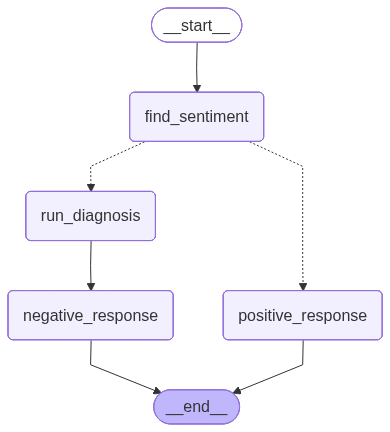

In [51]:
workflow

In [56]:
initial_state = {
    'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.'
}
workflow.invoke(initial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': 'Subject: Your High Urgency Bug Report - [Brief Bug Description] - Resolution & Update\n\nHi [User Name],\n\nI understand how incredibly frustrating it is when you hit a bug, especially one that disrupts your work and causes high urgency. Thank you for reaching out to us immediately and for clearly communicating your frustration – we truly appreciate you bringing this to our attention.\n\nI\'ve received your report regarding [briefly describe the bug, e.g., "the login loop issue," "the data saving error," or "the unexpected crash when doing X"]. Please accept our sincerest apologies for the inconvenience and disruption this has ca